# Fine-tuning Naver Movie Review Sentiment Classification with KoBERT on Amazon SageMaker
---

*Note: If you want to check the training results interactively or need background knowledge of BERT(Bi-directional Encoder Representations from Transformers), please refer to [this notebook](module1_kobert_nsmc_finetuning.ipynb) first.*

### Introduction

Amazon SageMaker manages the built-in deep learning frameworks, including MXNet, TensorFlow, PyTorch, and Chainer, as a managed Docker container, so you can easily train the model, or deploy to the endpoint using script without building a new Docker container with BYOC(Bring Your Own Container).

There are several ways to include dependency packages in a script.

- ***Option 1.*** Insert `requirements.txt` in the directory containing the entry point script. However, as of May 2020 TensorFlow framework does not support `requirements.txt` when setting script mode, so please use another option if you use TensorFlow.
- ***Option 2.*** Include a dependency package installation command in the inference script. For example,

```python
subprocess.call([sys.executable, '-m', 'pip', 'install', 'gluonnlp', 'torch', 'sentencepiece', 
                'onnxruntime', 'transformers', 'git+https://git@github.com/SKTBrain/KoBERT.git@master'])

```

In this hands-on lab, we use Option 1.

<br>

## 1. Preparing Data
---

Just download the data and upload it to Amazon S3. Since the data is a well-organized tabular data, uploading without any pre-processing is ready for training, but wrangling of actual data can be more complicated.

In [1]:
!pip install -q smdebug sagemaker-experiments

onnxruntime 1.3.0 has requirement numpy>=1.16.6, but you'll have numpy 1.16.4 which is incompatible.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import io, os
import random
import pandas as pd
import numpy as np
import time
import itertools
import random

import warnings
warnings.filterwarnings('ignore')

In [3]:
import boto3
import sagemaker

boto_session = boto3.Session()
sagemaker_session = sagemaker.Session(boto_session=boto_session)

In [4]:
!wget -O train.txt https://www.dropbox.com/s/374ftkec978br3d/ratings_train.txt?dl=1
!wget -O validation.txt https://www.dropbox.com/s/977gbwh542gdy94/ratings_test.txt?dl=1

--2020-06-03 11:53:45--  https://www.dropbox.com/s/374ftkec978br3d/ratings_train.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.1, 2620:100:601a:1::a27d:701
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/374ftkec978br3d/ratings_train.txt [following]
--2020-06-03 11:53:45--  https://www.dropbox.com/s/dl/374ftkec978br3d/ratings_train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbc548d0a61d02e99c48cd2b972.dl.dropboxusercontent.com/cd/0/get/A48iLyEbW0QuyOz1HdfSlxGB_uowOxZvQCRdBJn2UvimG9qM3Aj8K7wYQx3JdRw9hhGr7akWqxq6LYVKsRjmSGfFIJqnERfWIPe9Mvi2q-iuLC1Fr-LQX0fNs0e_5Hk_91Q/file?dl=1# [following]
--2020-06-03 11:53:46--  https://ucbc548d0a61d02e99c48cd2b972.dl.dropboxusercontent.com/cd/0/get/A48iLyEbW0QuyOz1HdfSlxGB_uowOxZvQCRdBJn2UvimG9qM3Aj8K7wYQx3JdRw9hhGr7akWqxq6LYVKsRjmSGfFIJqnERfWI

In [5]:
bucket = sagemaker_session.default_bucket()
prefix = 'data/KoBERT-nsmc'

In [6]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.txt')).upload_file('train.txt')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.txt')).upload_file('validation.txt')

In [7]:
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, 'train.txt')
s3_validation_data = 's3://{}/{}/validation/{}'.format(bucket, prefix, 'validation.txt')

<br>

## 2. Training
---

We fine-tune KoBERT models using MXNet and GluonNLP as a backend deep learning framework.
Amazon SageMaker can easily do the training by creating an MXNet estimator if you only have custom training scripts.


### Create Debugger Rules and Metric Definitions

Amazon SageMaker Debugger makes it easy to debug training processes such as intermediate outputs, weights, tensors.
Using AWS-managed Deep Learning containers, you can easily debug by writing a built-in rule without writing a separate debug callback function for data hooking. There is also a built-in rule for the NLP model, named `NLPSequenceRatio`. This rule calculates the percentage of specific tokens given to the rest of the input sequence, which is useful for optimizing performance. For example, you can calculate the percentage of padding sentence end (EOS) tokens in the input sequence. If the number of EOS tokens is too large, you need to consider an alternative bucketing strategy. 

In [8]:
from sagemaker.debugger import Rule, DebuggerHookConfig, CollectionConfig, rule_configs

hook_config = DebuggerHookConfig(
    hook_parameters={"save_interval": "100"},
    collection_configs=[CollectionConfig("weights")]
)

rules = [
    Rule.sagemaker(rule_configs.nlp_sequence_ratio())
]

# This metric definitions hooks the output string during training and validation using regular expressions 
# and store it to CloudWatch 
metric_defs = [
    {
        'Name': 'loss', 
        'Regex': 'loss=([0-9\.]+)',
    },
    {
        'Name': 'acc', 
        'Regex': 'acc=([0-9\.]+)',
    },    
]

### Create Experiments

Amazon SageMaker Experiments enables data scientists to construct, track, compare, and evaluate machine learning experiments. Since Machine Learning is an iterative process, data scientists need to experiment with combinations of data, algorithms, and parameters, observing incremental changes in model accuracy. This iterative process involves numerous model training and model versions. This makes it difficult to track configurations of good models and input settings. This makes it even more difficult to compare current experiments with experiments done in the past, in order to find opportunities for even more incremental improvement.

Amazon SageMaker Experiments allows you to automatically track inputs, parameters, configuration settings and results as an iterative process (trial). Data scientists can assign, group, and organize trials into experiments. Amazon SageMaker Experiments is integrated with Amazon SageMaker Studio, which allows you to visually view current and past experiments. Amazon SageMaker Studio also allows you to compare tests with key metrics, and to help you identify the best models.

In [9]:
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
import time

# Create an experiment
kobert_experiment = Experiment.create(
    experiment_name="MXNet-kobert-experiment-workshop",
    description="Binary Classification of Naver Movie Review")

In [10]:
# Create a trial
trial_name = f"mxnet-kobert-training-job-{int(time.time())}"
trial = Trial.create(
    trial_name=trial_name, 
    experiment_name=kobert_experiment.experiment_name
)


### Environment Variables 
When SageMaker performs training with `estimator.fit()`, the root path of the Docker container for training is `/opt/ml`, and training is performed by storing data in subdirectories of `/opt/ml`.
When the training is completed, the model parameters in the output folder are automatically compressed into `model.tar.gz` and saved in Amazon S3.
For reference, the path of the training Docker container is as follows.

```
/opt/ml/
    input/
        config/
        data/
    model/
    output/
        failure/
```

Typical environment variables are as follows.
 
- `SM_MODEL_DIR`: This is the path to store the completed model artifacts, `/opt/ml/model`, and model parameters in the model folder are automatically compressed into `model.tar.gz` and stored in Amazon S3 even if there is no separate processing when writing an additional script.
- `SM_CHANNEL_TRAIN`: This is the path to store training data; `/opt/ml/input/data/train`.
- `SM_CHANNEL_VALIDATION`: This is the path to store validation data; `opt/ml/input/data/validation`.

The following table shows examples of S3 path and container path according to environment variables.

|  S3 path  |  Environment variable  | Container path |
| :---- | :---- | :----| 
|  s3://bucket_name/prefix/train  |  `SM_CHANNEL_TRAIN`  | `/opt/ml/input/data/train`  |
|  s3://bucket_name/prefix/validation  |  `SM_CHANNEL_VALIDATION`  | `/opt/ml/input/data/validation`  |
|  s3://bucket_name/prefix/eval  |  `SM_CHANNEL_EVAL`  | `/opt/ml/input/data/eval`  |
|  s3://bucket_name/prefix/model.tar.gz  |  `SM_MODEL_DIR`  |  `/opt/ml/model`  |
|  s3://bucket_name/prefix/output.tar.gz  |  `SM_OUTPUT_DATA_DIR`  |  `/opt/ml/output/data`  |

Pleaes refer to the document below for more details.
https://github.com/aws/sagemaker-containers#list-of-provided-environment-variables-by-sagemaker-containers


### Training Script

The only code snippets you need to add in the training script are the SageMaker environment variables:

```python
parser = argparse.ArgumentParser()

# hyperparameters sent by the client are passed as command-line arguments to the script.
parser.add_argument('--num_epochs', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=64)  
parser.add_argument('--lr', type=float, default=5e-5)
parser.add_argument('--log_interval', type=int, default=50) 

# SageMaker environment variables
parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))      
parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))      
parser.add_argument('--model_output_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))

```

In [11]:
from sagemaker.mxnet import MXNet
role = sagemaker.get_execution_role()

mxnet_estimator = MXNet(entry_point='train.py',
                        source_dir='src',
                        role=role,
                        train_instance_type='ml.p3.8xlarge',
                        train_instance_count=1,
                        framework_version='1.6.0',
                        py_version='py3',
                        hyperparameters = {'num_epochs': 3, 
                                           'batch_size': 64,
                                           'lr': 5e-5,
                                           'log_interval': 50},
                        rules=rules,
                        metric_definitions=metric_defs,                        
                       )

Since it takes a lot of time to provision a training instance as well as to install dependent packages like GluonNLP and KoBERT, the total time is about 18 minutes for 1 epoch on `p3.2xlarge`. Please note, however, that not all of these fees are charged, and that the fee is charged only when the training instance is doing training.

*[Note]
Starting in August 2019, SageMaker can significantly reduce costs by using EC2 spot instances for training instances. We call this a managed spot instance and activation of this feature is easily possible with `train_use_spot_instances = 'True'`. For more information, please see the AWS blog below. <br>
https://aws.amazon.com/blogs/aws/managed-spot-training-save-up-to-90-on-your-amazon-sagemaker-training-jobs/*

In [12]:
%%time
mxnet_estimator.fit(inputs={'train': s3_train_data, 
                     'validation': s3_validation_data
                    },
                    experiment_config={
                        "ExperimentName": kobert_experiment.experiment_name, 
                        "TrialName": trial.trial_name,
                        "TrialComponentDisplayName": "Training"                        
                    }
                   )

INFO:sagemaker:Creating training-job with name: mxnet-training-2020-06-03-11-54-13-819


2020-06-03 11:54:14 Starting - Starting the training job...
2020-06-03 11:54:37 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*   NLPSequenceRatio: InProgress        
*
****************************************
......
2020-06-03 11:55:38 Starting - Preparing the instances for training.........
2020-06-03 11:57:06 Downloading - Downloading input data
2020-06-03 11:57:06 Training - Downloading the training image......
2020-06-03 11:58:00 Training - Training image download completed. Training in progress.2020-06-03 11:58:00,413 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2020-06-03 11:58:00,460 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch_size":64,"log_interval":50,"lr":5e-05,"num_epochs":3}', 'SM_USER_ENTRY_POINT': 'train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1

#015[..................................................]#015[..................................................]#015[..................................................]#015[..................................................]#015[..................................................]#015[..................................................]#015[..................................................]#015[█.................................................]#015[█.................................................]#015[█.................................................]#015[█.................................................]#015[█.................................................]#015[█.................................................]#015[█.................................................]#015[█.................................................]#015[██................................................]#015[██................................................]#015[██.........................................

�████████████████████.......................]#015[███████████████████████████.......................]#015[███████████████████████████.......................]#015[███████████████████████████.......................]#015[███████████████████████████.......................]#015[████████████████████████████......................]#015[████████████████████████████......................]#015[████████████████████████████......................]#015[████████████████████████████......................]#015[████████████████████████████......................]#015[████████████████████████████......................]#015[████████████████████████████......................]#015[█████████████████████████████.....................]#015[█████████████████████████████.....................]#015[█████████████████████████████.....................]#015[█████████████████████████████.....................]#015[█████████████████████████████.....................]#015[█████████████████████████████.....................]#01

using cached model
[2020-06-03 12:00:28.690 ip-10-2-76-60.ec2.internal:87 INFO json_config.py:90] Creating hook from json_config at /opt/ml/input/config/debughookconfig.json.
[2020-06-03 12:00:28.691 ip-10-2-76-60.ec2.internal:87 INFO hook.py:170] tensorboard_dir has not been set for the hook. SMDebug will not be exporting tensorboard summaries.
[2020-06-03 12:00:28.691 ip-10-2-76-60.ec2.internal:87 INFO hook.py:215] Saving to /opt/ml/output/tensors
[2020-06-03 12:00:28.715 ip-10-2-76-60.ec2.internal:87 INFO hook.py:351] Monitoring the collections: input_sequence, losses
[2020-06-03 12:00:28.718 ip-10-2-76-60.ec2.internal:87 WARNING hook.py:839] var is not NDArray or list or tuple of NDArrays, module_name:bertmodel0_word_embed_embedding0 Symbol
[2020-06-03 12:00:28.718 ip-10-2-76-60.ec2.internal:87 WARNING hook.py:839] var is not NDArray or list or tuple of NDArrays, module_name:bertmodel0_word_embed_embedding0 Symbol
[2020-06-03 12:00:28.718 ip-10-2-76-60.ec2.internal:87 WARNING hook.

INFO:__main__:[Epoch 0 Batch 50/592] loss=0.6255, lr=0.0000140, acc=0.622
INFO:__main__:[Epoch 0 Batch 100/592] loss=0.4723, lr=0.0000283, acc=0.702
INFO:__main__:[Epoch 0 Batch 150/592] loss=0.3774, lr=0.0000426, acc=0.745
INFO:__main__:[Epoch 0 Batch 200/592] loss=0.3449, lr=0.0000492, acc=0.770
INFO:__main__:[Epoch 0 Batch 250/592] loss=0.3376, lr=0.0000477, acc=0.787
INFO:__main__:[Epoch 0 Batch 300/592] loss=0.3157, lr=0.0000461, acc=0.799
INFO:__main__:[Epoch 0 Batch 350/592] loss=0.3094, lr=0.0000445, acc=0.809
INFO:__main__:[Epoch 0 Batch 400/592] loss=0.2969, lr=0.0000429, acc=0.817
INFO:__main__:[Epoch 0 Batch 450/592] loss=0.2962, lr=0.0000413, acc=0.824
INFO:__main__:[Epoch 0 Batch 500/592] loss=0.2842, lr=0.0000398, acc=0.829
INFO:__main__:[Epoch 0 Batch 550/592] loss=0.2755, lr=0.0000382, acc=0.834
INFO:__main__:=== Start Validation ===
INFO:__main__:Validation loss=1.1269, acc=0.885
INFO:__main__:Epoch 0 evaluation result: train_acc 0.83722, train_loss 0.2740584500133991

<br>

## 3. Analyze
---

### Description

In [13]:
job_name = mxnet_estimator.latest_training_job.name
print('Training job name: {}'.format(job_name))
client = mxnet_estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)

Training job name: mxnet-training-2020-06-03-11-54-13-819


In [14]:
description

{'TrainingJobName': 'mxnet-training-2020-06-03-11-54-13-819',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:143656149352:training-job/mxnet-training-2020-06-03-11-54-13-819',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-143656149352/mxnet-training-2020-06-03-11-54-13-819/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch_size': '64',
  'log_interval': '50',
  'lr': '5e-05',
  'num_epochs': '3',
  'sagemaker_container_log_level': '20',
  'sagemaker_enable_cloudwatch_metrics': 'false',
  'sagemaker_job_name': '"mxnet-training-2020-06-03-11-54-13-819"',
  'sagemaker_program': '"train.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-143656149352/mxnet-training-2020-06-03-11-54-13-819/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-training:1.6.0-gpu-py3',
  'TrainingInputM


### Debugger

In [15]:
from smdebug.trials import create_trial
trial = create_trial(mxnet_estimator.latest_job_debugger_artifacts_path())

[2020-06-03 12:44:13.302 ip-172-16-60-96:83398 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-143656149352/mxnet-training-2020-06-03-11-54-13-819/debug-output


In [16]:
trial

[2020-06-03 12:44:14.620 ip-172-16-60-96:83398 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-06-03 12:44:15.640 ip-172-16-60-96:83398 INFO trial.py:210] Loaded all steps


<smdebug.trials.s3_trial.S3Trial object at 0x7fe3c5c726a0>:(
    name=debug-output,
    path=s3://sagemaker-us-east-1-143656149352/mxnet-training-2020-06-03-11-54-13-819/debug-output/,
    steps=[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500],
    collections=['losses', 'biases', 'all', 'default', 'weights', 'gradients', 'input_sequence'],
    tensor_names=['softmaxcrossentropyloss0_output_0'],
)

In [17]:
path = mxnet_estimator.latest_job_debugger_artifacts_path()
print('Tensors are stored in: {}'.format(path))

Tensors are stored in: s3://sagemaker-us-east-1-143656149352/mxnet-training-2020-06-03-11-54-13-819/debug-output


### Experiments

Here, we create a filter that only looks for Trial Components with DisplayName equal to `"Training"`.
You will find the `TrialComponentDisplayName : "Training"` set above.

In [18]:
search_expression = {
    "Filters":[
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [19]:
import pandas as pd 
pd.options.display.max_columns = 10

from sagemaker.analytics import ExperimentAnalytics
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=sagemaker_session, 
    experiment_name=kobert_experiment.experiment_name,
    search_expression=search_expression
)

table = trial_component_analytics.dataframe(force_refresh=True)
display(table)

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,...,softmaxcrossentropyloss0_output_0_GLOBAL - Max,softmaxcrossentropyloss0_output_0_GLOBAL - Avg,softmaxcrossentropyloss0_output_0_GLOBAL - StdDev,softmaxcrossentropyloss0_output_0_GLOBAL - Last,softmaxcrossentropyloss0_output_0_GLOBAL - Count
0,mxnet-training-2020-06-03-11-54-13-819-aws-tra...,Training,arn:aws:sagemaker:us-east-1:143656149352:train...,763104351884.dkr.ecr.us-east-1.amazonaws.com/m...,1.0,...,0.727276,0.256927,0.142705,0.21771,20


### Training Job Analytics

The SageMaker API makes it easy to view training job metrics as dataframes.
Of course, the training log can also be checked through CloudWatch.

In [20]:
from sagemaker.analytics import TrainingJobAnalytics
latest_job_name = mxnet_estimator.latest_training_job.job_name
acc_metric = TrainingJobAnalytics(training_job_name=latest_job_name, metric_names=['acc']).dataframe()
loss_metric = TrainingJobAnalytics(training_job_name=latest_job_name, metric_names=['loss']).dataframe()

In [21]:
acc_metric.head()

,timestamp,metric_name,value
0,0.0,acc,0.622000
1,60.0,acc,0.723500
2,120.0,acc,0.785333
3,180.0,acc,0.813000
4,240.0,acc,0.829000


In [22]:
loss_metric.head()

,timestamp,metric_name,value
0,0.0,loss,0.625500
1,60.0,loss,0.424850
2,120.0,loss,0.332733
3,180.0,loss,0.303150
4,240.0,loss,0.285300


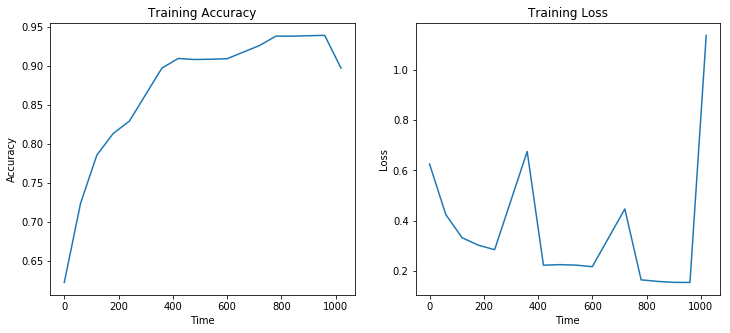

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,5)
ax1 = plt.subplot(121)
ax1.plot(acc_metric['timestamp'], acc_metric['value'])
ax1.set_xlabel("Time")
ax1.set_ylabel("Accuracy")
ax1.set_title('Training Accuracy')

ax2 = plt.subplot(122)
ax2.plot(loss_metric['timestamp'], loss_metric['value'])
ax2.set_xlabel("Time")
ax2.set_ylabel("Loss")
ax2.set_title('Training Loss')
plt.show()

### Clean up the Experiment

The experiment name is unique to your account and region, so if you don not use it, we strongly recommend to delete it.

The `kobert_experiment` object created above is deleted as a parameter to the cleanup function below. This action deletes the associated Trial Component, Trial, and finally deletes the experiment.

In [24]:
import boto3

sess = boto3.Session()
sm = sess.client('sagemaker')
from smexperiments.trial_component import TrialComponent

def cleanup(experiment):
    for trial_summary in experiment.list_trials():
        trial = Trial.load(sagemaker_boto_client=sm, trial_name=trial_summary.trial_name)
        for trial_component_summary in trial.list_trial_components():
            tc = TrialComponent.load(
                sagemaker_boto_client=sm,
                trial_component_name=trial_component_summary.trial_component_name)
            trial.remove_trial_component(tc)
            try:
                # comment out to keep trial components
                tc.delete()
            except:
                # tc is associated with another trial
                continue
            # to prevent throttling
            time.sleep(.5)
        trial.delete()
    experiment.delete()
    print("The experiemnt is deleted")

cleanup(kobert_experiment)

The experiemnt is deleted
